# Cuda Simulator

In [1]:
"""Setup"""
import numpy as np
import sys
#from google.colab import drive
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
from matplotlib.patches import Circle, Rectangle
from mpl_toolkits.mplot3d import Axes3D
from viz_cuda import *
from optics_cuda import *

#drive.mount("/content/gdrive")
#np.set_printoptions(
#    edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)
#)
# the code in this notebook is formatted with Black https://black.vercel.app/ using 3.7, which is what this says:
print(sys.version)

CuPy version 11.0.0
3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]


/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
%%time
""" Generate some photons from the LED.

For now use Lambertian, it's pretty close.
TODO: use the Cree distribution
Say the units are like 100 microns?  so like 1mm square?
TODO: calibrate the size
TODO: calibrate the output
"""

###
photon_count = np.int32(25000000)
source_size = np.float32(10)
###
photons = LambertianSource(source_size, source_size).make_photons(photon_count)
print(f"LED emitted photons: {photons.size()}")

LED emitted photons: 25000000
CPU times: user 220 ms, sys: 52.1 ms, total: 272 ms
Wall time: 291 ms


CPU times: user 99.7 ms, sys: 0 ns, total: 99.7 ms
Wall time: 98.9 ms


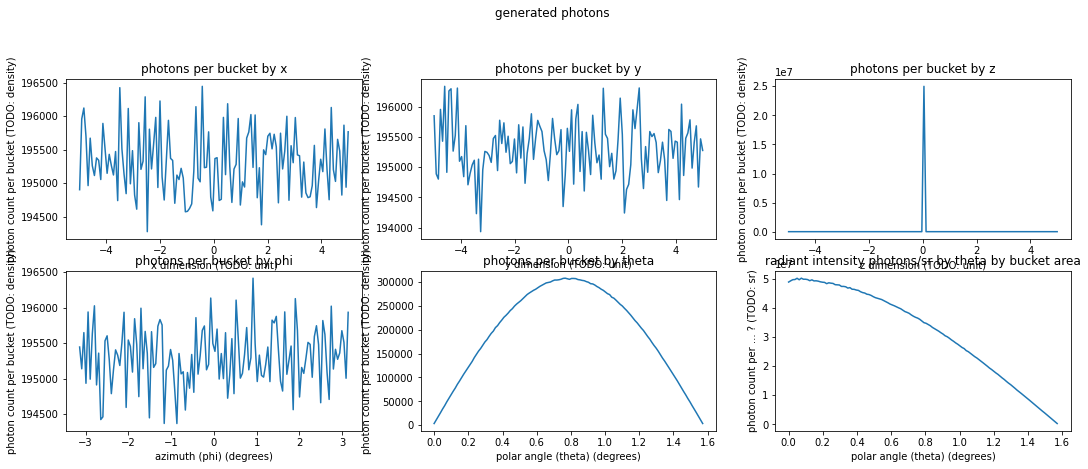

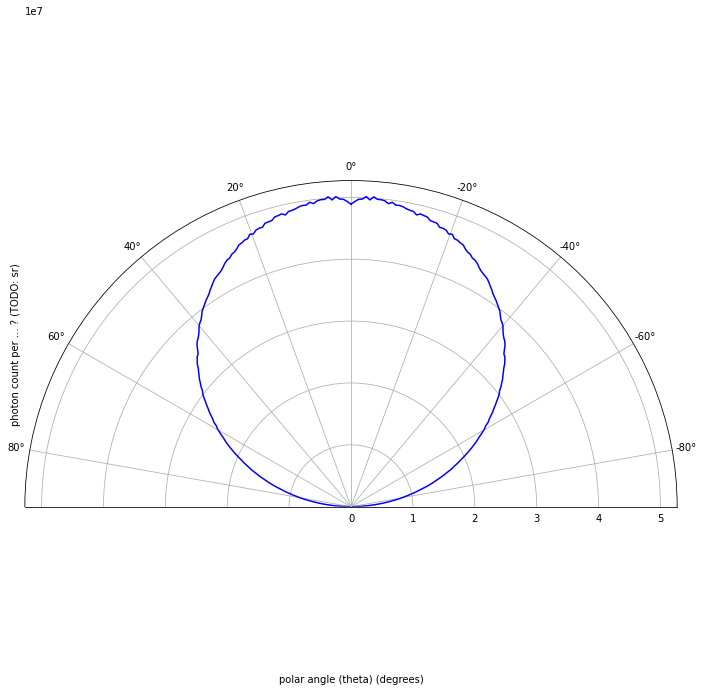

In [3]:
%%time
""" Look at the distributions of the generated photons."""
plot_histogram_slices(photons, "generated photons",
                      x_min = -source_size/2, x_max = source_size/2,
                      y_min = -source_size/2, y_max = source_size/2,
                      z_min = -5, z_max = 5,
                      theta_max = np.pi/2)

In [4]:
%%time
"""Look at the photons in 3d."""
source_box = [-source_size/2, source_size/2, -source_size/2, source_size/2, 0]
source_sample = photons.sample()
plot_3d([source_sample], ray_lengths=[1], boxes=[source_box], labels=['LED'], colors=[0xffff00])

Output()

CPU times: user 23.7 ms, sys: 6.51 ms, total: 30.2 ms
Wall time: 28.6 ms


In [5]:
%%time
""" Propagate the photons to the diffuser.

Most arrive at the diffuser surface.
Some are absorbed by the imperfectly reflective lightbox.
A square profile (or undersquare) helps keep the intensity even at the top. 
"""
###
lightbox_height = 400
lightbox_size = 400
###

lightbox = Lightbox(height = lightbox_height, size = lightbox_size)
lightbox.propagate(photons)
print(f"diffuser incident photons: {photons.size()}")

diffuser incident photons: 21127541
CPU times: user 4.02 s, sys: 326 µs, total: 4.02 s
Wall time: 4.04 s


In [6]:
%%time
box_sample = photons.sample()
lightbox_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height]
plot_3d([source_sample, box_sample], ray_lengths=[100, 100],
        boxes=[source_box, lightbox_box], labels=['LED','lightbox'], colors=[0xffff00, 0x00ffff])

Output()

CPU times: user 37 ms, sys: 281 µs, total: 37.3 ms
Wall time: 32.5 ms


CPU times: user 98.3 ms, sys: 106 µs, total: 98.4 ms
Wall time: 96.6 ms


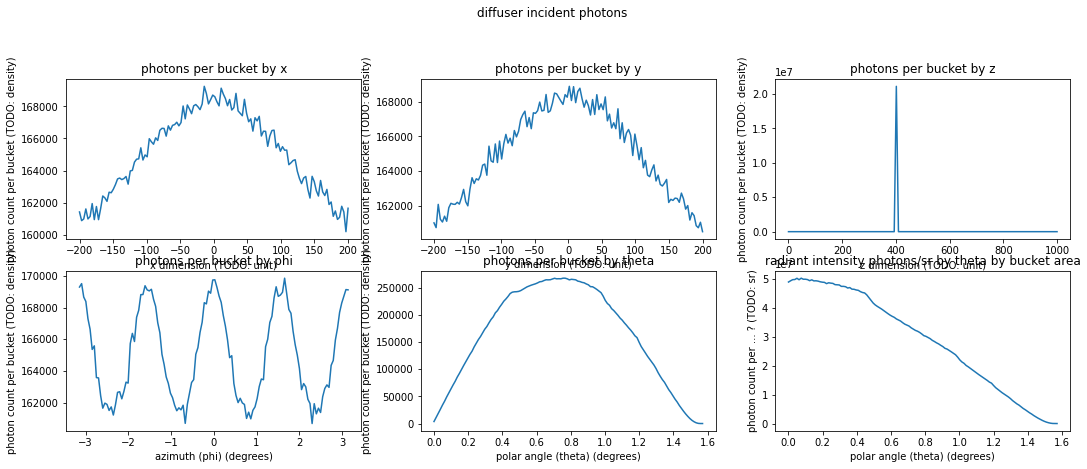

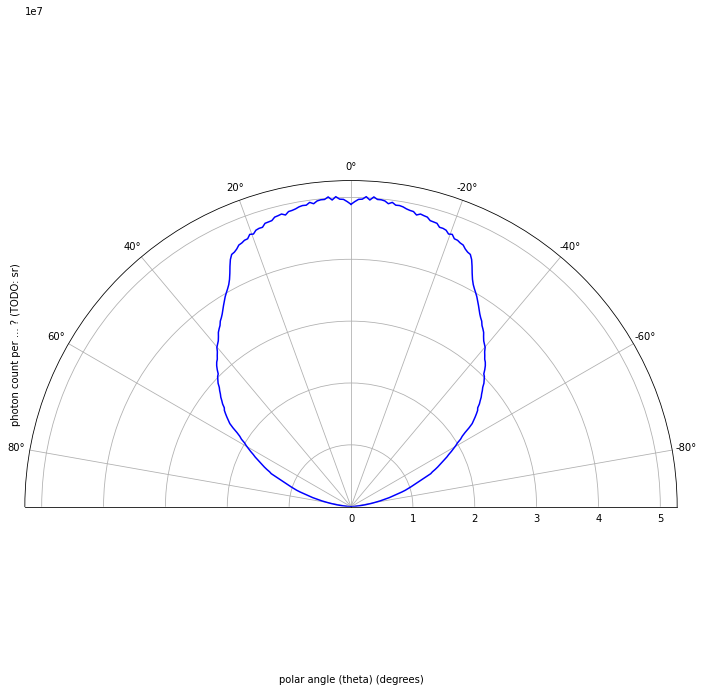

In [7]:
%%time
""" Show distributions of diffuser incident photons."""
plot_histogram_slices(photons, "diffuser incident photons",
                      x_min=-200, x_max=200,
                      y_min=-200, y_max=200,
                      z_min=0, z_max=1000, 
                      theta_max = np.pi/2)

In [8]:
%%time
""" Diffuse through the diffuser. """
diffuser = Diffuser(g = np.float32(0.64), absorption = np.float32(0.16))
diffuser.diffuse(photons)
print(f"diffuser-transmitted photons: {photons.size()}")

diffuser-transmitted photons: 17749750
CPU times: user 82.5 ms, sys: 0 ns, total: 82.5 ms
Wall time: 81.9 ms


CPU times: user 136 ms, sys: 322 µs, total: 136 ms
Wall time: 133 ms


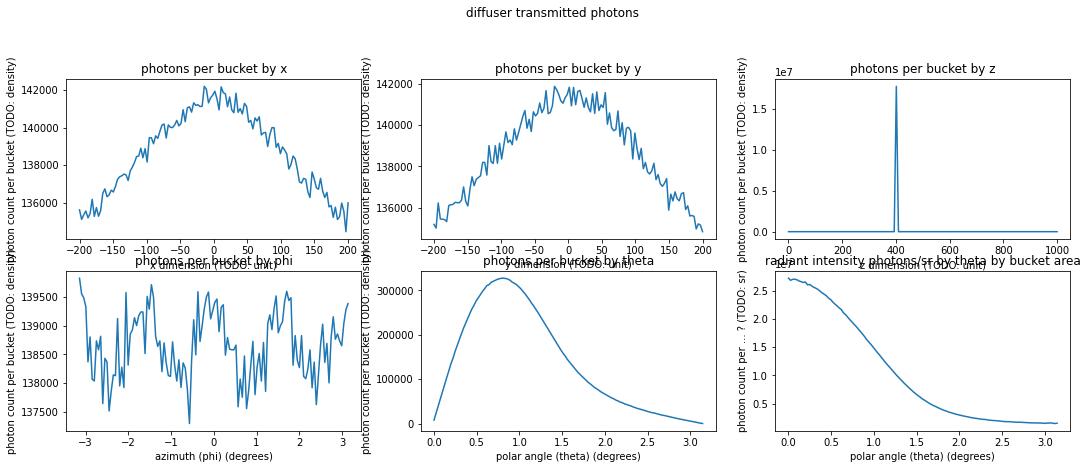

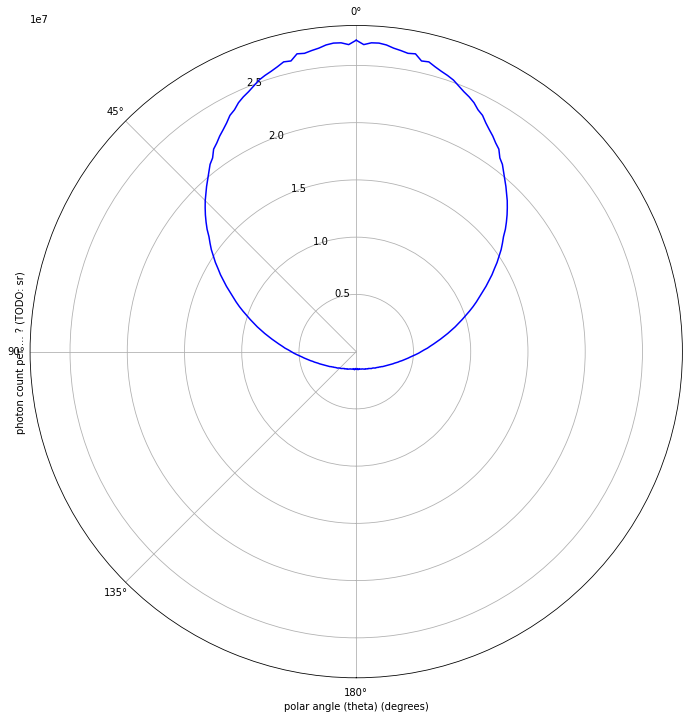

In [9]:
%%time
""" Show the distributions of photons transmitted by the diffuser.

Notice the distribution goes all the way to 180 degrees, a small fraction
of the incident photons are scattered downward.
"""
plot_histogram_slices(photons, "diffuser transmitted photons",
                      x_min=-200, x_max=200,
                      y_min=-200, y_max=200,
                      z_min=0, z_max=1000, 
                      theta_max = np.pi)

In [10]:
%%time
""" Show the LED-produced and diffuser-transmitted photons in 3d. """
diff_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height+1]
diff_sample = photons.sample()
plot_3d([source_sample, box_sample, diff_sample],
        ray_lengths=[10, 10, 100],
        boxes=[source_box, lightbox_box, diff_box],
        labels=['LED', 'lightbox', 'diffuser'],
        colors=[0xffff00, 0x00ffff, 0xff00ff])

Output()

CPU times: user 67.1 ms, sys: 47.4 ms, total: 115 ms
Wall time: 42.5 ms


In [11]:
%%time
""" Propagate diffuser-transmitted photons to the (far away) reflector. """
# TODO: units.
# for now, unit is 100 microns, so
# min distance might be ... 10000 = 1 meter?  maybe less?
# max distance is probably ~100000 = 10 meters
# reflector size might be 10cm square (=1000)

reflector_distance = np.float32(100000)
propagate_to_reflector(photons, location = reflector_distance, size = np.float32(1000))
print(f"reflector-incident photons: {photons.size()}")

reflector-incident photons: 467
CPU times: user 99.5 ms, sys: 0 ns, total: 99.5 ms
Wall time: 99.5 ms


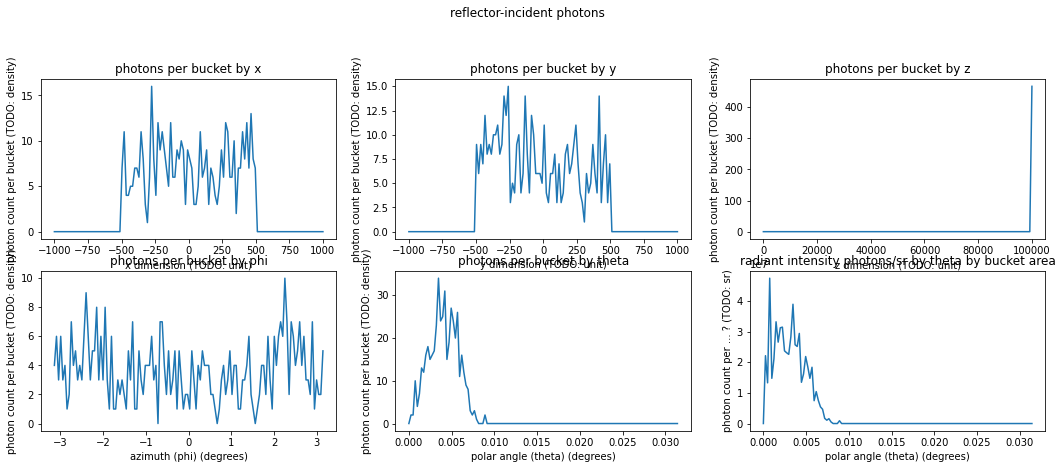

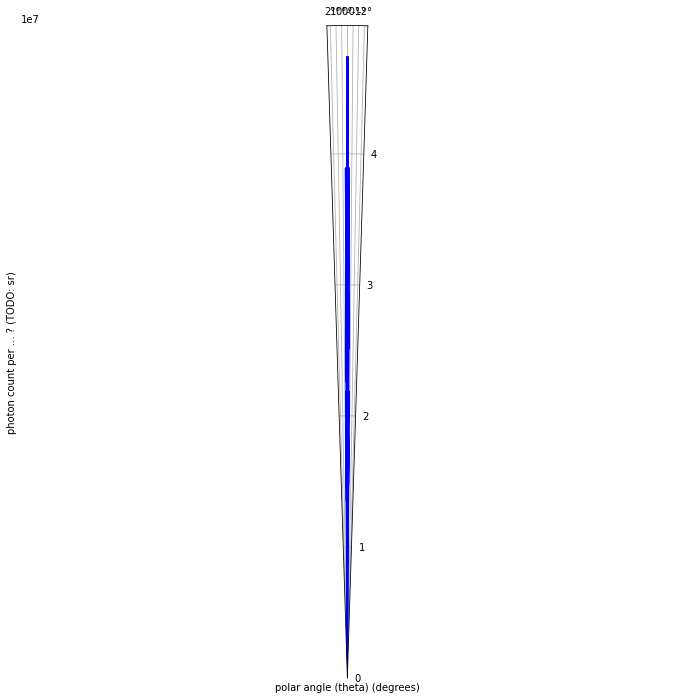

In [12]:
""" Show the distributions of reflector-incident photons """
plot_histogram_slices(photons, "reflector-incident photons",
                      x_min=-1000, x_max=1000,
                      y_min=-1000, y_max=1000,
                      z_min=0, z_max=reflector_distance,
                     theta_max = np.pi/100)

In [13]:
""" Show the generated, diffuser-transmitted, and reflector-incident photons in 3d. """
print(f"reflector-incident photons: {photons.size()}")
plot_3d([source_sample, box_sample, diff_sample],
        ray_lengths=[10, 10, 100],
        boxes=[source_box, lightbox_box, diff_box],
        labels=['LED', 'lightbox', 'diffuser'],
        colors=[0xffff00, 0x00ffff, 0xff00ff])
reflector_sample = photons.sample()
reflector_box = [-500, 500, -500, 500, reflector_distance]
plot_3d([reflector_sample],
        ray_lengths=[1000],
        boxes=[reflector_box],
        labels=['reflector'],
        colors=[0x808000])

reflector-incident photons: 467


Output()

Output()

In [14]:
""" Reflect the incident photons at the reflector. """
print(f"reflector-incident photons: {photons.size()}")

# TODO: guess at absorption

diffuser = Diffuser(g = np.float32(0.64), absorption = np.float32(0.0))
diffuser.diffuse(photons)
print(f"reflected photons: {photons.size()}")


reflector = Diffuser(g = -0.9925, absorption=0.0)
reflector.diffuse(photons)




reflector-incident photons: 467
reflected photons: 467


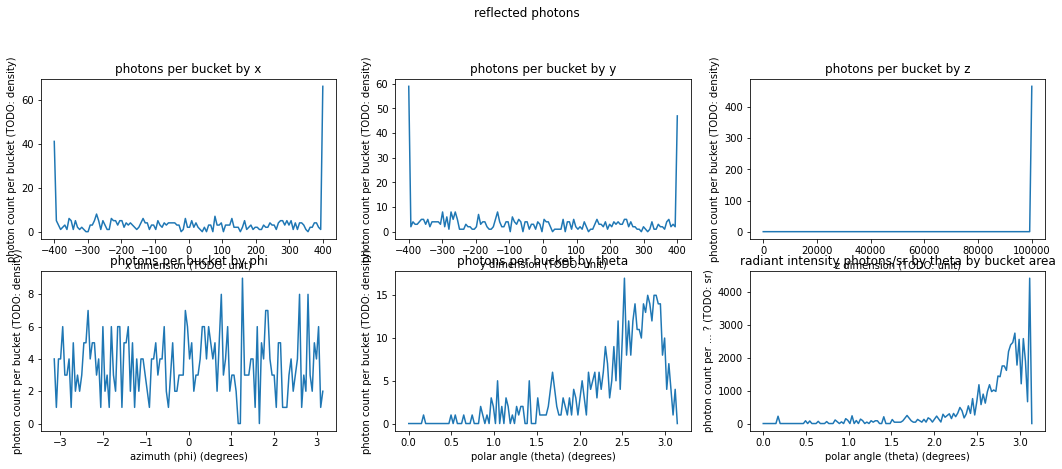

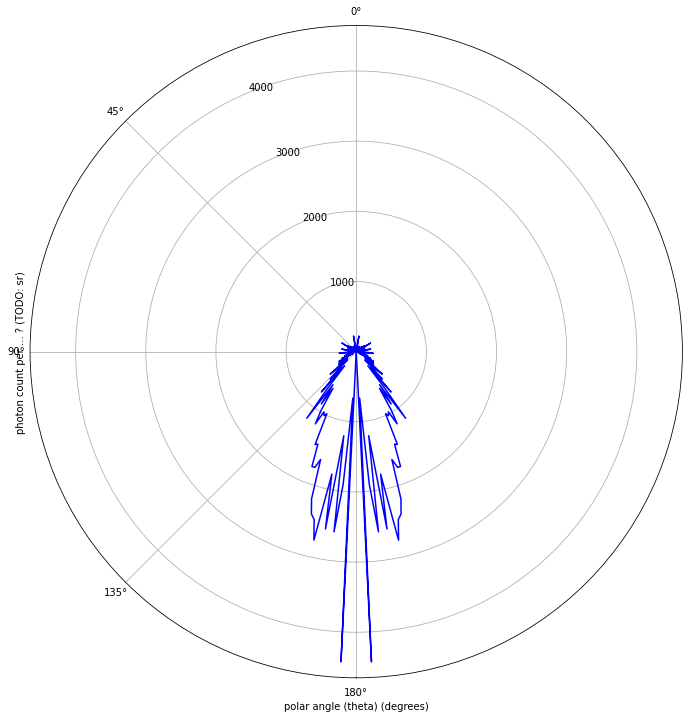

In [15]:
""" Show the distributions of reflected photons """
plot_histogram_slices(photons, "reflected photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=reflector_distance)

In [16]:
""" Show the generated, transmitted, reflector-incident and reflected photons in 3d. """
reflected_sample = photons.sample()
reflected_box = [-500, 500, -500, 500, reflector_distance - 1]
plot_3d([reflector_sample, reflected_sample],
        ray_lengths=[1000, 1000],
        boxes=[reflector_box, reflected_box],
        labels=['reflector', 'reflected'],
        colors=[0x808000, 0x008080])


Output()

# ==== START HERE ====

In [ ]:
""" Propagate the reflected photons to the camera plane. """
print(f"reflected photons: {Photon.countAlive(photons)}")
propagateToCamera(photons, location = lightbox_size) # make the camera height even with the diffuser
print(f"camera-incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
photons_at_camera_plane_viz = Photon.sample(photons, 1000)

In [ ]:
""" Show the distributions of camera-plane photons """
plot_histogram_slices(photons, "camera-plane photons", x_min=-1000, x_max=1000, y_min=-1000, y_max=1000, z_min=0, z_max=1000)

In [ ]:
""" Show the reflected photons in 3d."""
plot_rays([reflected_photons_viz, photons_at_camera_plane_viz], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 10000,
          rectangles=[source_box, lightbox_box, reflector_box])

In [ ]:
""" Show the distributions of reflected photons, close up """
plot_histogram_slices(photons, "reflected photons", x_min=-2000, x_max=2000, y_min=-2000, y_max=2000, z_min=0, z_max=1000)

In [ ]:
""" Look closer at the neighborhood of the detector. """
plot_rays([photons_at_camera_plane_viz], 
          elev = 90, azim = 0, size = 5000, arrow_length = 1000,
          rectangles=[source_box, lightbox_box])